# Road segmentation

In [1]:
%matplotlib inline

import numpy as np
import os,sys

from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

from helpers import *
from plots import *

%load_ext autoreload
%autoreload 2

## Parameters

In [2]:
# Model and hyper-parameters grid.

#model = linear_model.LogisticRegression(class_weight="balanced", solver="lbfgs")
#param_grid = {'C': [1e5, 1e4, 1e3, 1e2, 1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4]}

model = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]}

In [3]:
# Number of training images
n = 100

# Number of folds for the cross-validation.
k = 5

# Fix randomness (integer) or not (None)
seed = 0

# AIcrowd expects patches of 16 by 16 pixels.
patch_size = 16

# percentage of pixels > 1 required to assign a foreground label to a patch (default=0.25)
foreground_threshold = 0.20

# Extraction function
#extraction_func = extract_features_2d
extraction_func = extract_features_6d

# Preprocessing function
#preproc = None
preproc = preprocessing.StandardScaler()
#preproc = preprocessing.Normalizer()

# Create a submission file ?
submit = True

## Data extraction

In [4]:
# Load a set of images
imgs, gt_imgs = load_training_images(n)

In [5]:
# Extract patches from all images
img_patches = get_patches(imgs, patch_size)
gt_patches = get_patches(gt_imgs, patch_size)

In [6]:
# Get features for each image patch
X, Y = get_data_from_patches(img_patches, gt_patches, foreground_threshold, extraction_func)

In [7]:
# Preprocessing
if preproc is not None:
    preproc = preproc.fit(X)
    X = preproc.transform(X)
print(X)

[[ 1.1942403   1.2037009   1.2506635  -0.48477727 -0.41597438 -0.39878875]
 [ 1.4677233   1.4833219   1.5353929  -0.94753265 -0.8892673  -0.83655745]
 [ 0.8020816   0.7600718   0.78922534  0.06760904  0.14033253  0.19810897]
 ...
 [ 0.06431407  0.00315676  0.03402698  0.33710027  0.3073349   0.3095325 ]
 [ 0.05412711 -0.10465694  0.01334922 -0.7948372  -0.7408869  -0.71891475]
 [ 0.04547825  0.01416922  0.05886115  0.55259955  0.53377324  0.5424422 ]]


## Cross-validation and parameters tuning

In [8]:
split = StratifiedShuffleSplit(n_splits=k, random_state=seed)
search = GridSearchCV(model, param_grid, cv=split, scoring="f1")
search.fit(X,Y)
model = search.best_estimator_
score = search.best_score_

In [9]:
print(score)
print(model.get_params())

0.554479718578506
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}


## Training and predictions

In [10]:
# Training
model.fit(X, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [11]:
# Predict on the training set
Z = model.predict(X)

TPR = true_positive_rate(Z, Y)
TNR = true_negative_rate(Z, Y)
FPR = false_positive_rate(Z, Y)
FNR = false_negative_rate(Z, Y)
F1 = f_score(Z, Y)
print('True positive rate = ' + str(TPR))
print('True negative rate = ' + str(TNR))
print('False positive rate = ' + str(FPR))
print('False negative rate = ' + str(FNR))
print('F1-score = ' + str(F1))

True positive rate = 0.145312
True negative rate = 0.653904
False positive rate = 0.074304
False negative rate = 0.12648
F1-score = 0.5914108032429264


In [12]:
# Predict on test set and create submission
if submit:
    create_submission(model, extraction_func, patch_size, preproc)

## Comparison of groundtruth and prediction

In [13]:
idx = 1
img = imgs[idx]
# Run predictions
Xi = get_data_from_img(img, extraction_func, patch_size)
if preproc is not None:
    Xi = preproc.transform(Xi)
Zi = model.predict(Xi)

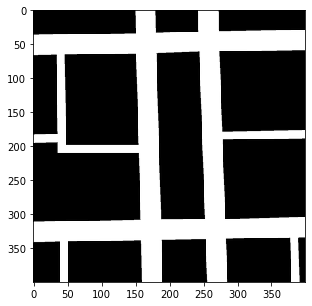

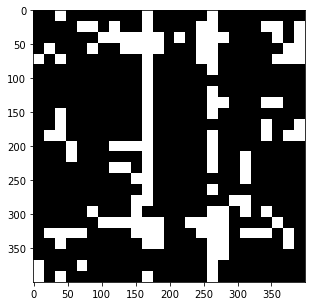

In [14]:
w = img.shape[0]
h = img.shape[1]
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)
show_img(gt_imgs[idx])
show_img(predicted_img)

## Visualization of a single test image

In [15]:
# Load a test image
img_idx = 1

img_path = "Datasets/test_set_images/test_{0}/test_{0}.png".format(img_idx)
img = load_image(img_path)

In [16]:
# Run predictions
Xi = get_data_from_img(img, extraction_func, patch_size)
if preproc is not None:
    Xi = preproc.transform(Xi)
Zi = model.predict(Xi)

In [17]:
if Xi.shape[1] == 2:
    show_data_points(Xi, Zi)

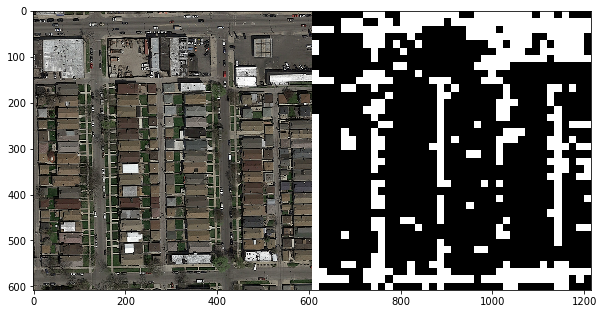

In [18]:
# Display prediction as an image
w = img.shape[0]
h = img.shape[1]
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)
show_img_concatenated(img, predicted_img)

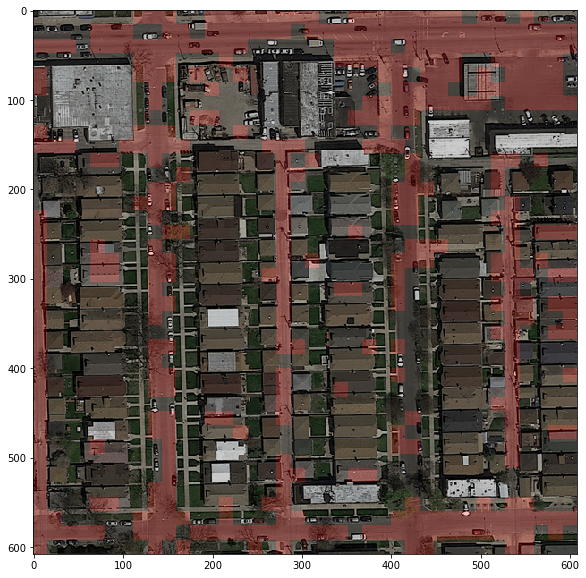

In [19]:
show_img_overlay(img, predicted_img)